# Image Segmentation

# Importing Libraries

In [77]:
# If I had more time and resources I would Have worked on https://www.youtube.com/watch?v=HloNNIW1kx4
import re 
import os 
from pathlib import Path
import numpy as np
from patchify import patchify
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import os 
from pathlib import Path
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
import seaborn as sns
import segmentation_models_pytorch as smp
import torchmetrics
# I was not able to get the coco dataset working in my pc[pycocotools], due to some depenedencies error even after 
# I created seprate virtual enviroments, which should not be happening, due to the time limit restricions, 
# I chose the dataset from teh kaggle.
# Some of my other projects can be acessed through my Github.
# NLP : - https://github.com/Kds888/NLP Conatins a lot of fine tuning tasks
# CNN Theory : - https://github.com/Kds888/Artificial-Intelligence/blob/main/CNN's.ipynb
# Gan's Architecture: - [Image Generation] https://github.com/Kds888/Artificial-Intelligence/blob/main/GANS-Basic.ipynb

# Data Preprocessing

In [2]:
def cretae_folders():
    Folders = [
        'Train',
        'Val',
        'Test'
    ]
    for folder in Folders:
        if not os.path.exists(folder):
            folder_imgs = f"{folder}/images"
            folder_msks = f"{folder}/masks"
            os.makedirs(folder_imgs) if not os.path.exists(folder_imgs) else print("Folder Already Exist")
            os.makedirs(folder_msks) if not os.path.exists(folder_msks) else print("Folder Already Exist")
cretae_folders()

In [3]:
from PIL import Image
def create_patches(src, dest_path):
    path_split = os.path.split(src)
    tile_num = re.findall(r'\d+', path_split[0])
    image = Image.open(src)
    image = np.asarray(image)
    if len(image.shape) > 2: 
        patches = patchify(image, (320, 320, 3), step=300) 
        file_name_wo_extension = Path(src).stem
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                patch = patches[i, j, 0]
                num = i * patches.shape[1] + j
                patch_img = Image.fromarray(patch)
                patch_img.save(f"{dest_path}/{file_name_wo_extension}_tile_{tile_num[0]}_patch_{num}.png") 

In [4]:
import os
all_image_paths =[]
all_masks_path= []
data_dir = 'data'
for i in range(1, 9):
    tile_dir = os.path.join(data_dir, f'Tile {i}')
    images_dir = os.path.join(tile_dir, 'images')
    masks_dir = os.path.join(tile_dir, 'masks')
    if os.path.exists(images_dir) and os.path.exists(masks_dir):
        image_files = os.listdir(images_dir)
        mask_files = os.listdir(masks_dir)        
        image_paths = [os.path.join(images_dir, fname) for fname in image_files]
        all_image_paths.extend(image_paths)
        mask_paths = [os.path.join(masks_dir, fname) for fname in mask_files]
        all_masks_path.extend(mask_paths)

In [5]:
for i in range(len(all_image_paths)):
    if int(all_image_paths[i].split('\\')[1][-1]) > 4 and int(all_masks_path[i].split('\\')[1][-1]) > 4:
        create_patches(all_image_paths[i],'Train/images')
        create_patches(all_masks_path[i],'Train/masks')
    elif int(all_image_paths[i].split('\\')[1][-1]) == 1 and int(all_masks_path[i].split('\\')[1][-1]) == 1:
        create_patches(all_image_paths[i],'Val/images')
        create_patches(all_masks_path[i],'Val/masks')
    elif int(all_image_paths[i].split('\\')[1][-1]) == 3 and int(all_masks_path[i].split('\\')[1][-1]) == 3:
        create_patches(all_image_paths[i],'Test/images')
        create_patches(all_masks_path[i],'Test/masks')  

In [58]:
class SegmentDataset(Dataset):
    def __init__(self,path_name) ->None:
        super().__init__()
        self.image_names = os.listdir(f"{path_name}/images")
        self.image_path = [f"{path_name}/images/{i}" for i in self.image_names]
        self.mask_names = os.listdir(f"{path_name}/masks")
        self.mask_path = [f"{path_name}/masks/{i}" for i in self.mask_names]
        # Check 
        self.img_stem = [Path(i).stem for i in self.image_path]
        self.mask_stem= [Path(i).stem for i in self.mask_path]
        self.img_msk_stem= set(self.img_stem) & set(self.mask_stem)
        self.image_paths = [i for i in self.image_path if Path(i).stem in self.img_msk_stem]
    def __len__(self):
        return len(self.img_msk_stem)
    def convert_mask(self,mask):
        mask[mask == 155] =0 # Unlabeled
        mask[mask == 44] = 1 # Building
        mask[mask == 91] = 2  # land
        mask[mask == 171] =3 # water
        mask[mask == 172] =4 # road
        mask[mask == 212] =5 # vegeration
        # This information I have decoded using the json file
        return mask
    def __getitem__(self,index):
        image =cv2.imread(self.image_paths[index])
        image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image= image.transpose((2,0,1))# because we need BS,C,H,W
        mask =cv2.imread(self.mask_path[index],0)
        mask = self.convert_mask(mask)
        return image,mask

# Modelling

In [60]:
Device = "cuda" if torch.cuda.is_available() else "cpu"

In [62]:
train_ds = SegmentDataset(path_name='Train')

In [63]:
train_dataloader = DataLoader(train_ds,batch_size=4)

In [64]:
val_ds = SegmentDataset(path_name='Val')
val_dataloader = DataLoader(val_ds,batch_size=4) 

In [65]:
import ssl
import torch
import segmentation_models_pytorch as smp
ssl._create_default_https_context = ssl._create_unverified_context
# As the modle is hosted on http, and its not having an ssl certificate we needed the above code.
model = smp.FPN(
    encoder_name='se_resnext50_32x4d',
    encoder_weights='imagenet',
    classes=6,
    activation='sigmoid'
)
model.to(Device)

FPN(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu)

In [66]:
optimizer= torch.optim.Adam([dict(params=model.parameters(),lr=0.0001)])

In [67]:
critrion=nn.CrossEntropyLoss()# we can have the smp.losses.DiceLoss(model='multiclass')

In [69]:
train_losses,val_losses =[],[]
for e in range(50):
    print(e)
    model.train()
    running_train_loss,running_val_loss =0,0
    for i,data in enumerate(train_dataloader):
        image_i,mask_i =data
        image=image_i.to(Device)
        mask=mask_i.to(Device)
        optimizer.zero_grad()
        output = model(image.float())
        train_loss = critrion(output.float(),mask.long())
        train_loss.backward()
        optimizer.step()
        running_train_loss+=train_loss.item()
    train_losses.append(running_train_loss)
    model.eval()
    with torch.no_grad():
        for i,data in enumerate(val_dataloader):
            image_i,mask_i =data
            image=image_i.to(Device)
            mask=mask_i.to(Device)
            output = model(image.float())
            val_loss = critrion(output.float(),mask.long())
            running_val_loss+=val_loss.item()
        val_losses.append(running_val_loss)
        print(f"EPOCH: - {e}: Train Loss: {running_train_loss}, Val Loss: {running_val_loss}")         

0
EPOCH: - 0: Train Loss: 214.98701345920563, Val Loss: 10.869033813476562
1
EPOCH: - 1: Train Loss: 201.3895182609558, Val Loss: 10.700478553771973
2
EPOCH: - 2: Train Loss: 192.93400394916534, Val Loss: 10.747839093208313
3
EPOCH: - 3: Train Loss: 187.69973921775818, Val Loss: 10.758334279060364
4
EPOCH: - 4: Train Loss: 184.1947921514511, Val Loss: 10.762101531028748
5
EPOCH: - 5: Train Loss: 182.2418566942215, Val Loss: 10.76683783531189
6
EPOCH: - 6: Train Loss: 180.9741771221161, Val Loss: 10.720417737960815
7
EPOCH: - 7: Train Loss: 180.05717253684998, Val Loss: 10.628036737442017
8
EPOCH: - 8: Train Loss: 179.2719646692276, Val Loss: 10.64409625530243
9
EPOCH: - 9: Train Loss: 178.7760704755783, Val Loss: 10.688774943351746
10
EPOCH: - 10: Train Loss: 178.15125930309296, Val Loss: 10.655646920204163
11
EPOCH: - 11: Train Loss: 177.86344599723816, Val Loss: 10.687142610549927
12
EPOCH: - 12: Train Loss: 177.50872039794922, Val Loss: 10.683380365371704
13
EPOCH: - 13: Train Loss:

[Text(0.5, 1.0, 'Train Loss')]

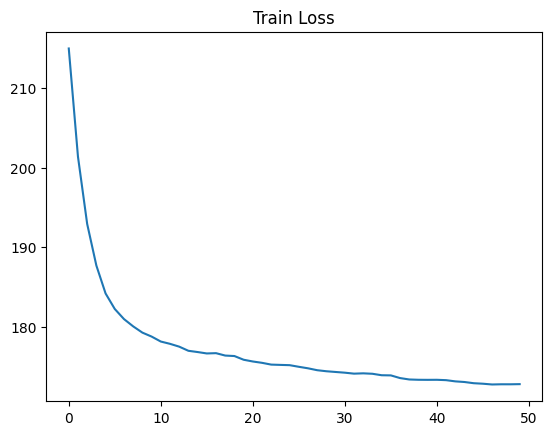

In [70]:
# Train loss
sns.lineplot(x=range(len(train_losses)),y=train_losses).set(title="Train Loss")

[Text(0.5, 1.0, 'Val Loss')]

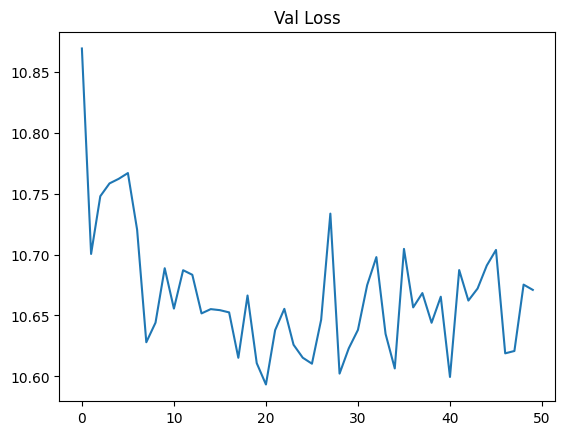

In [72]:
sns.lineplot(x=range(len(val_losses)),y=val_losses).set(title="Val Loss")

In [73]:
# We need to experiment with some of the hyper parameters, to get more optimal results.

# Model Evaluations

In [74]:
torch.save(model.state_dict(),"FPN_epochs_50_CELOSS_state_dict.pth")

In [78]:
test_ds = SegmentDataset('Test')

In [119]:
test_dataloader =  DataLoader(test_ds,batch_size=1,shuffle=True)

In [80]:
pixel_accuracies = []
intersection_over_unions=[]
metric_iou =torchmetrics.JaccardIndex(num_classes=6,task ='multiclass').to(Device)

In [99]:
with torch.no_grad():
    for data in test_dataloader:
        inputs, outputs = data
        true = outputs.to(torch.float32).to(Device) 
        predicted_class = torch.max(pred, 1)[1].to(Device) 
        true_classes = true.to(torch.long)
        correct_pixels = (true_classes == predicted_class).sum().item()
        totol_pixels = true.size(1)*true.size(2)
        pixel_accuracies.append(correct_pixels/totol_pixels)
        iou=metric_iou(predicted_class.float(),true_classes).item()
        intersection_over_unions.append(iou)

In [101]:
print(f"Median Pixel Accuracy:{np.median(pixel_accuracies)*100}")

Median Pixel Accuracy:86.9140625


In [103]:
print(f"Median IOU:{np.median(intersection_over_unions)*100}") 
# This is not very good, but can be improved, as it should be around 1 for a better model.

Median IOU:38.41646909713745


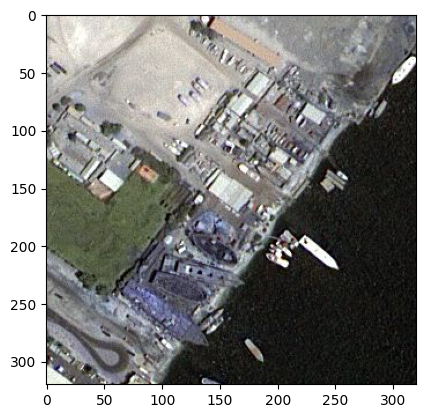

In [120]:
image_test,mask = next(iter(test_dataloader))
plt.imshow(np.transpose(image_test[0,:,:,:].cpu().numpy(),(1,2,0)))

In [121]:
with torch.no_grad():
    image_test = image_test.float().to(Device)
    output = model(image_test)

In [122]:
output_cpu = output.cpu().squeeze().numpy()
output_cpu =output_cpu.transpose((1,2,0))

In [123]:
output_cpu = output_cpu.argmax(axis=2)

Text(0.5, 1.0, 'True Mask')

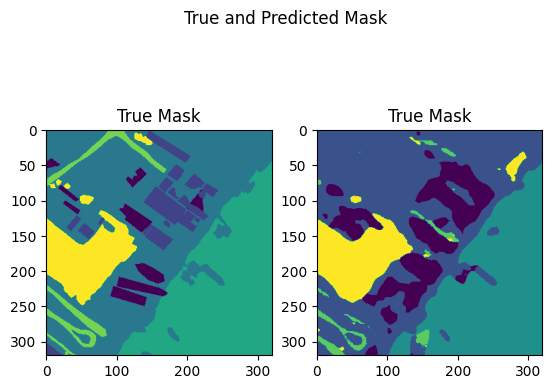

In [125]:
fig,ax=plt.subplots(nrows=1,ncols=2)
fig.suptitle("True and Predicted Mask")
ax[0].imshow(mask[0,:,:])
ax[1].imshow(output_cpu) 
ax[0].set_title("True Mask")
ax[1].set_title("True Mask")
# we can see that the model is trying to predcit the mask